In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
plt.style.use('fivethirtyeight')
sns.set_style('whitegrid')

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/GUC-DM/W2025/refs/heads/main/data/music_genres.csv')
df.head()

,genres,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,popularity,key
0,21st century classical,0.979333,0.162883,1.602977e+05,0.071317,0.606834,0.361600,-31.514333,0.040567,75.336500,0.103783,27.833333,6
1,432hz,0.494780,0.299333,1.048887e+06,0.450678,0.477762,0.131000,-16.854000,0.076817,120.285667,0.221750,52.500000,5
2,8-bit,0.762000,0.712000,1.151770e+05,0.818000,0.876000,0.126000,-9.180000,0.047000,133.444000,0.975000,48.000000,7
3,a cappella,0.676557,0.538961,1.906285e+05,0.316434,0.003003,0.172254,-12.479387,0.082851,112.110362,0.448249,45.820071,7
4,abstract,0.459210,0.516167,3.431965e+05,0.442417,0.849667,0.118067,-15.472083,0.046517,127.885750,0.307325,43.500000,1


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2972 entries, 0 to 2971
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   genres            2972 non-null   object 
 1   acousticness      2972 non-null   float64
 2   danceability      2972 non-null   float64
 3   duration_ms       2972 non-null   float64
 4   energy            2972 non-null   float64
 5   instrumentalness  2972 non-null   float64
 6   liveness          2972 non-null   float64
 7   loudness          2972 non-null   float64
 8   speechiness       2972 non-null   float64
 9   tempo             2972 non-null   float64
 10  valence           2972 non-null   float64
 11  popularity        2972 non-null   float64
 12  key               2972 non-null   int64  
dtypes: float64(11), int64(1), object(1)
memory usage: 302.0+ KB


Reading the data and chechking whether it is clean or not

knowing the data is clean from:

Checked for missing values in numerical features: none found checking data types: all numeric features are float or int No duplicates detected Select only numeric features for K-Means clustering

so, there will be no need to make data cleaning step as the data is already cleaned

In [4]:
# List of numerical features selected for clustering
num_features = ['acousticness', 'danceability', 'duration_ms', 'energy',
                'instrumentalness', 'liveness', 'loudness', 'speechiness',
                'tempo', 'valence', 'key']

X = df[num_features] # Extract only the numerical features from the DataFrame

# Check for missing values in the selected numeric features
# Ensures data is clean and no preprocessing is needed
df[num_features].isnull().sum()

acousticness        0
danceability        0
duration_ms         0
energy              0
instrumentalness    0
liveness            0
loudness            0
speechiness         0
tempo               0
valence             0
key                 0
dtype: int64

First selecting the numerical features for clustering. These features are continuous, which is required for K-Means to calculate distances between points.

Before applying K-Means, checking for missing values in these features and found none. so, this confirms that the data is clean, and no further data cleaning is needed for these numerical columns.

The genres column is not used as a feature because it is categorical. But, it will be used for labeling and interpreting clusters after K-Means clustering.

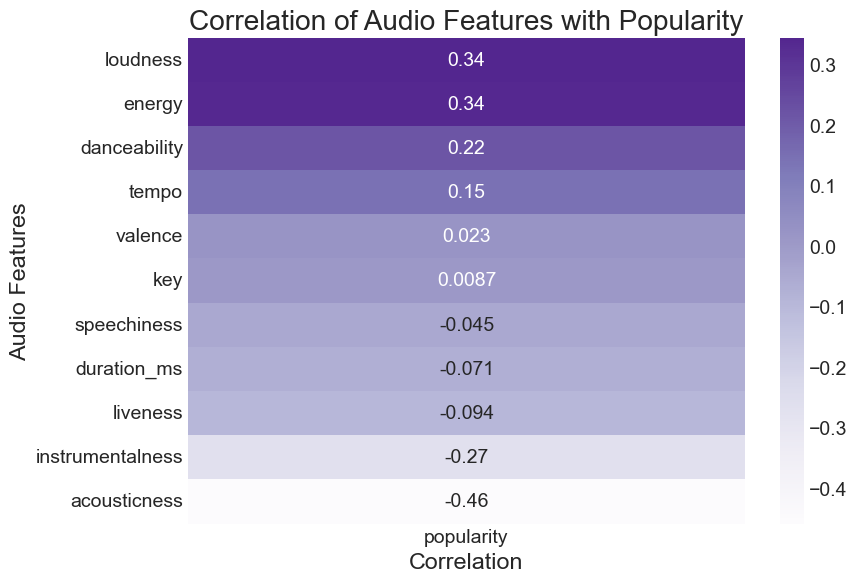

In [5]:
# Compute correlation of each numerical feature with the target variable 'popularity'
popularity_corr = (
    df[num_features + ['popularity']]  # include numeric features and popularity
    .corr()['popularity']              # calculate correlation of all features with 'popularity'
    .drop('popularity')                # remove popularity with itself
    .sort_values(ascending=False)      # sort correlations descending to find strongest positive correlations
)

popularity_corr # Show the correlations

plt.figure(figsize=(8,6)) # Set the figure size

# convert to DataFrame for heatmap, show correlation values on heatmap, color map, center color at 0 for clear positive or negative contrast
sns.heatmap(popularity_corr.to_frame(), annot=True, cmap='Purples', center=0)
plt.title('Correlation of Audio Features with Popularity') # Set the chart title
plt.xlabel('Correlation') # Label the x-axis
plt.ylabel('Audio Features') # Label the Y-axis
plt.show() # show the plot

**The two biggest factors affecting popularity are:**

Loudness (correlation ≈ 0.34)
Songs with higher loudness tend to be more popular.

As louder tracks often feel more impactful or energetic which make them more engaging for listeners.

Energy (correlation ≈ 0.34)
Songs with higher energy also tend to be more popular.

As energetic songs are more exciting and lively which generally attracts more plays on streaming platforms.

**The code:**

First calculate the correlation of each feature with popularity, correlation values range from -1 to 1, indicating the strength and direction of the linear relationship.

Then, remove self-correlation, since popularity correlates perfectly with itself, remove it to focus only on other features.

Next sort correlations, sorted the correlations in descending order to easily identify the features most positively correlated with popularity.

Then visualization with heatmap, using a heatmap to visualize the correlations. which provides a clear, effective view of which features have the strongest relationships with popularity. Positive correlations are shown in darker purple, negative correlations in lighter shades, and values near zero are neutral.

chosing a heatmap to visualize the correlation of audio features with popularity because it allows to quickly and clearly see the strength and direction of relationships between multiple features at once. The color intensity highlights strong positive or negative correlations, making it easier to identify the features that most influence popularity compared to reading raw numbers in a table, also, heatmaps are used here because the data is numerical, showing correlations between continuous variables where each cell represents a correlation value between two numerical features, so the heatmap effectively visualizes the relationships among multiple numeric variables at once.

The heatmap shows the strength and direction of correlation for each feature. Features with higher positive correlations (closer to 1) suggest that as the feature increases, popularity tends to increase. Features with negative correlations suggest an inverse relationship with popularity.

Most popular genre: basshall (Average popularity: 80.6666666666667)
Least popular genre: albany ny indie (Average popularity: 0.0)


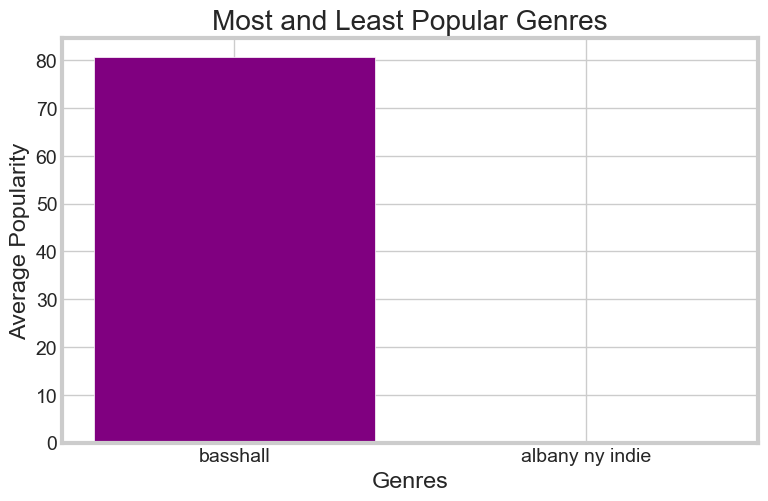

In [6]:
popularity_by_genre = df.groupby('genres')['popularity'].mean() # Groups the DataFrame by 'genres' and calculates the mean popularity for each genre

most_popular_value = popularity_by_genre.max() # Get the maximum average popularity value

most_popular_genre = popularity_by_genre[popularity_by_genre == most_popular_value].index[0] # Select the genre that has this maximum popularity

least_popular_value = popularity_by_genre.min() # Get the minimum average popularity value

least_popular_genre = popularity_by_genre[popularity_by_genre == least_popular_value].index[0] # Select the genre that has this minimum popularity

print(f"Most popular genre: {most_popular_genre} (Average popularity: {most_popular_value})") # Show the most popular genre and its average popularity

print(f"Least popular genre: {least_popular_genre} (Average popularity: {least_popular_value})") # Show the least popular genre and its average popularity

genres = [most_popular_genre, least_popular_genre] # Create a list of genres to plot

values = [most_popular_value, least_popular_value] # Create a list of corresponding popularity values

colors = ['purple', 'blue'] # Purple for most popular, blue for least popular

plt.figure(figsize=(8,5)) # Set the figure size
plt.bar(genres, values, color=colors) # Plot the bar chart with the colors
plt.title('Most and Least Popular Genres') # Set the chart title
plt.ylabel('Average Popularity') # Label the y-axis
plt.xlabel('Genres') # Label the x-axis
plt.show() # Show the plot

Most popular and least popular genre:

Most popular genre is basshall (Average popularity: 80.6666666666667)

Least popular genre is albany ny indie (Average popularity: 0.0)

**The code:**

First calculate average popularity per genre as it groups the dataset by the genres column and calculates the mean popularity for each genre.

Then find the most popular genre using boolean indexing, finds the maximum value in the popularity Series and selects the genres that have this maximum value, the genre name is shown from the index.

Next, find the least popular genre using boolean indexing, finds the minimum value in the popularity Series and selects the genres with this minimum popularity, the genre name is shown from the index.

Then, print the results, prints the most and least popular genres with their average popularity values.

Next, prepare data for plotting, creates a list of genres to plot most and least popular, their corresponding popularity values and a list of colors where purple for the most popular and blue for the least popular.

Finally, show the bar chart, bar chart is created showing the most and least popular genres, the figure size is set, bars are colored according to the list, the chart is titled, x- and y-axis are labeled, x-axis labels are rotated for readability, and the chart is shown.

Using bar chart because it is the most effective way to compare discrete categories, clear comparison between categories:

Each bar represents a genre, and the height of the bar corresponds to its average popularity.

It allows an immediate visual comparison of the most and least popular genres.

Then bar charts are simple, especially when comparing a small number of categories, also, the difference in popularity between genres is easily visible by comparing bar heights.

Different colors where purple for most popular and blue for least popular make the chart visually clear and emphasize the distinction between the extremes.

Also, suitable for discrete, non-numerical categories since genres are categorical data, a bar chart is more appropriate.

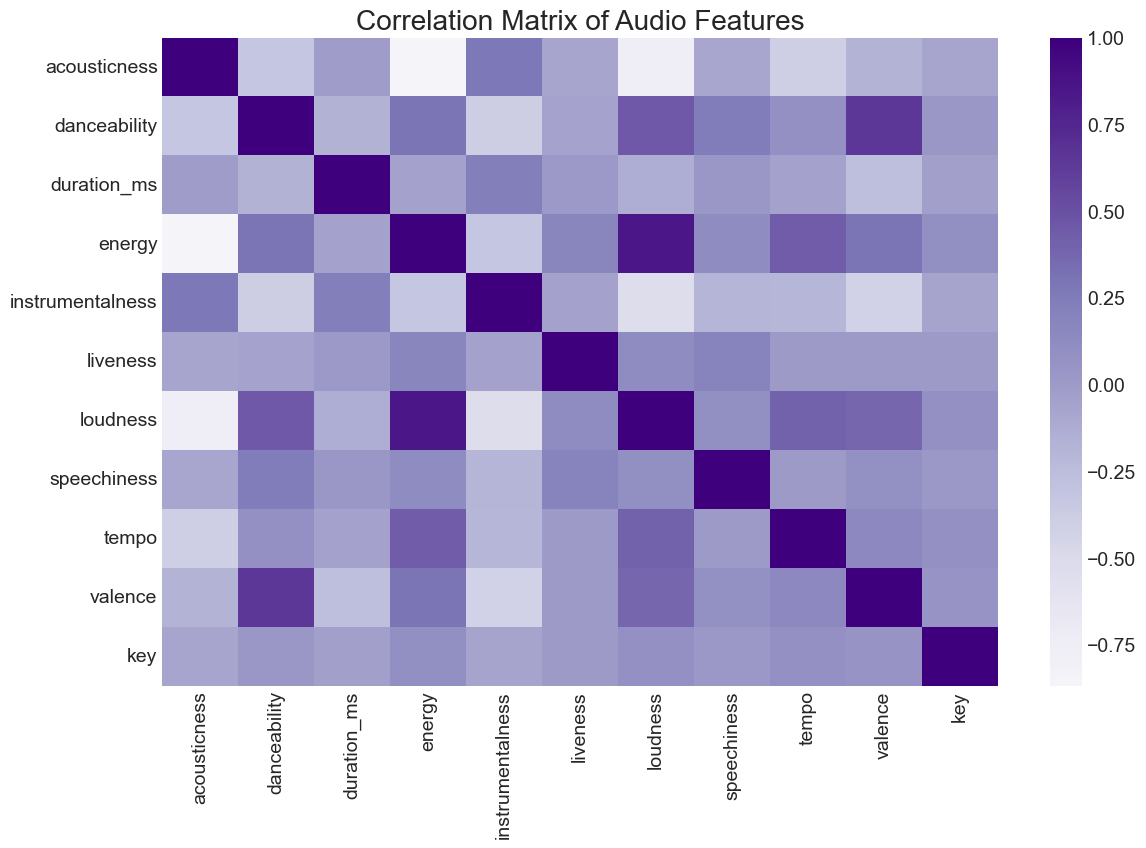

In [7]:
corr_matrix = df[num_features].corr()  # Calculate correlation between all numerical features

corr_pairs = corr_matrix.unstack().sort_values(ascending=False)  # Convert matrix to series of feature pairs and sort by correlation
corr_pairs = corr_pairs[corr_pairs < 1]  # Remove self-correlations
corr_pairs.head(2)  # Show the two highest correlated feature pairs

plt.figure(figsize=(12,8))  # Create a figure of size 12x8 for the heatmap
sns.heatmap(
    corr_matrix,  # Pass the correlation matrix to the heatmap
    cmap='Purples',  # Use a purple color for the heatmap
    center=0  # Center the color map at 0
)
plt.title('Correlation Matrix of Audio Features')  # Add a title to the heatmap
plt.show()  # Show the heatmap

**The most correlated pairs of attributes:**

Loudness and Energy Correlation, this pair shows dark purple color, showing a strong positive correlation.
Where an increase in the energy of a track tends to be highly associated with an increase in its overall. While, lower energy tracks tend to be quieter

Instrumentalness and Speechiness Correlation, this pair shows lightest colors, showing a strong negative correlation.
Where a track with a high instrumentalness is highly associated with a low speechiness score, and vice versa, where, if a song is very instrumental, it cannot be very speechy, and if it is very speechy it is less likely to be considered instrumental.

**The code:**

First calculate the correlation matrix of the numerical features in num_features, where each cell in this matrix represents the correlation between two features.

Then, finds the top correlated feature pairs by:

Converting the correlation matrix into a list of feature pairs.

Sorting these pairs from highest to lowest correlation.

Removing self-correlations where a feature is correlated with itself.

Showing the two highest correlated feature pairs.

Finally, the code plots the correlation matrix as a heatmap, the figure size is set, purple color is used for visualization, correlations around 0 are centered in the color map, title is added and the chart is shown.

The heatmap shows visually how strongly each numerical feature is correlated with others, darker or more intense colors highlight features that are strongly positively or negatively correlated.

Heatmap helps to see patterns, where can easily spot clusters of features that move together or inversely. Also, easier than raw numbers where table of correlation values can be overwhelming for many features. A heatmap uses colors to show the magnitude and direction of correlation. Moreover, helps in feature selection and analysis as highly correlated features may indicate redundancy, which is important for data analysis, modeling, or dimensionality reduction.

Top 10 most common words in genre names:
[('pop', 240), ('indie', 237), ('rock', 183), ('metal', 132), ('classical', 106), ('hop', 103), ('hip', 102), ('jazz', 96), ('folk', 80), ('punk', 66)]


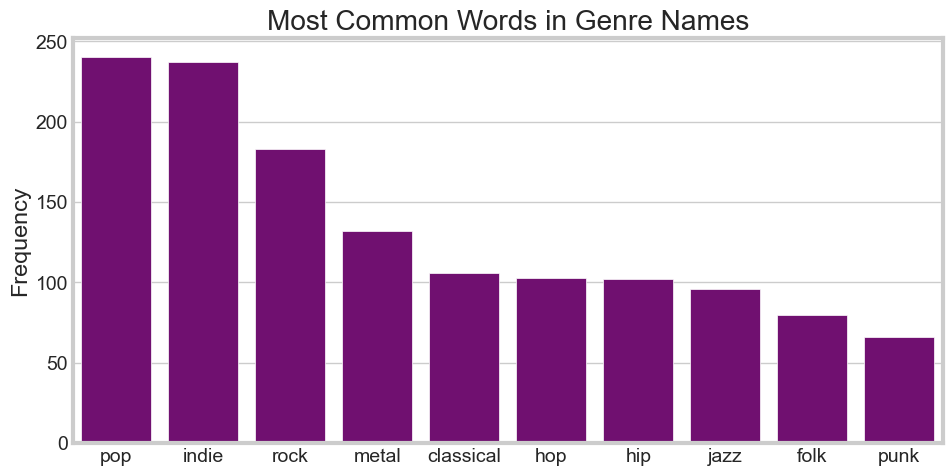

In [8]:
from collections import Counter  # Import the Counter class to count frequency of words

words = " ".join(df['genres']).split() # Join all genre names into a single string then split into individual words
word_freq = Counter(words) # Create a Counter object to count the frequency of each word in the list of words
top_words = word_freq.most_common(10) # Get the top 10 most common words and their frequencies

print("Top 10 most common words in genre names:") # Print the top 10 most common words along with their frequencies
print(top_words)

plt.figure(figsize=(10,5))  # Set the figure size

# Extract words (w[0]) for x-axis and frequencies (w[1]) for y-axis
sns.barplot(x=[w[0] for w in top_words], y=[w[1] for w in top_words], color='purple')

plt.title("Most Common Words in Genre Names") # Set the title
plt.ylabel("Frequency")  # Label the y-axis
plt.show() # Show the plot

**Main genre categories with the most sub-genres are:**

Pop: appears 240 times, showing a wide variety of sub-genres which indicates that pop music has a large number of sub-genres.

Indie: appears 237 times, showing a wide variety of sub-genres.

Rock: appears 183 times, showing a wide variety of sub-genres.

**The code:**

First, import the Counter class from the collections module which is used to count how frequently each word appears.

Then, extracting words from genre names where all values in the genres column are joined into a single string and then split into individual words to allow the analysis to focus on commonly used words within genre names.

Next, counting word frequencies where a counter object is created to count how many times each word appears in the genre names to identify patterns in how genres are named.

Then, select the top 10 most common words.

Then, print results top 10 most common words and their frequencies.

Next, creating the bar chart to visualize the frequency of the most common words, figure size is set for clarity, the bars are colored purple for visual consistency, and a descriptive title and y-axis label are added.

Finally, show the chart

In [9]:
from sklearn.preprocessing import StandardScaler  # Import StandardScaler to normalize feature values

scaler = StandardScaler() # Create a StandardScaler object

# Fit the scaler to the data X and transform X so that each feature has mean = 0 and standard deviation = 1
X_scaled = scaler.fit_transform(X)

First, the StandardScaler class is imported.

Then, a scaler object is created, which will be responsible for applying the normalization.

Finally, fit_transform(X) is applied to the dataset X. As during this step, the scaler: fits the data by computing the mean and standard deviation for each feature then transforms the data by subtracting the mean and dividing by the standard deviation, as a result, all features in X_scaled have a mean of 0 and a standard deviation of 1.

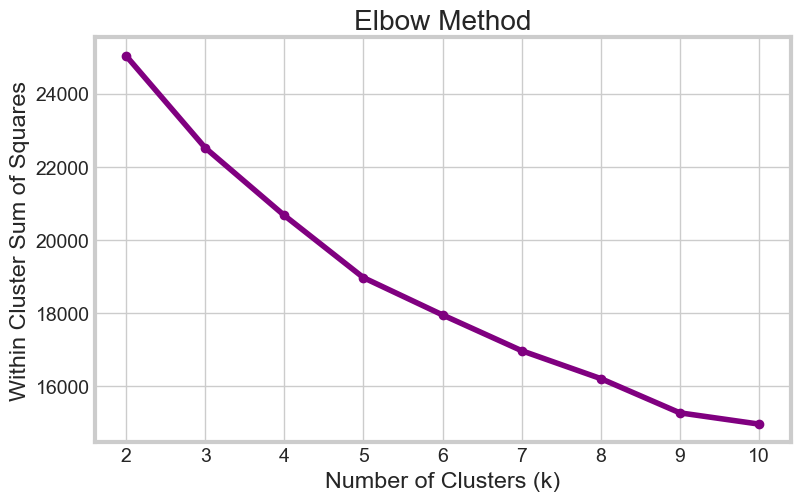

In [10]:
from sklearn.cluster import KMeans  # Import K-Means clustering algorithm
import matplotlib.pyplot as plt  # Import matplotlib for plotting

k_values = range(2, 11)  # Define a range of k values
inertia_values = []  # List to store inertia values for each k

for k in k_values:   # Loop over each k value
    kmeans = KMeans(
        n_clusters=k,  # Set the number of clusters
        random_state=42,  # Fix random state
        n_init=10  # Run K-Means 10 times and keep the best result
    )
    kmeans.fit(X_scaled)  # Fit the K-Means model on the scaled data
    inertia_values.append(kmeans.inertia_)  # Store the inertia for this k

plt.figure(figsize=(8,5)) # Set the figure size
plt.plot(k_values, inertia_values, marker='o', color='purple') # Plot k values vs inertia
plt.title('Elbow Method')  # Set the plot title
plt.xlabel('Number of Clusters (k)')  # Label the x-axis
plt.ylabel('Within Cluster Sum of Squares')  # Label the y-axis
plt.show() # Show the plot

First, the KMeans algorithm is imported, range of possible cluster numbers (k_values) is defined, since using one cluster does not provide meaningful grouping.

Then, empty list is created to store the inertia values. Inertia, also known as the Within-Cluster Sum of Squares, where Lower values indicate more cohesive clusters.

Then, loops through each value of k. For every iteration, a K-Means model is created with the current number of clusters and fitted to the standardized dataset. After fitting, the inertia value for that model is recorded.

Finally, the inertia values are plotted against the number of clusters. The resulting curve shows a sharp decrease at first and then starts to level off. The point where the decrease becomes gradual is known as the elbow point, this point represents a good balance between having clusters and avoiding unnecessary complexity, and it is used as the optimal number of clusters.

Best k based on silhouette score: 2


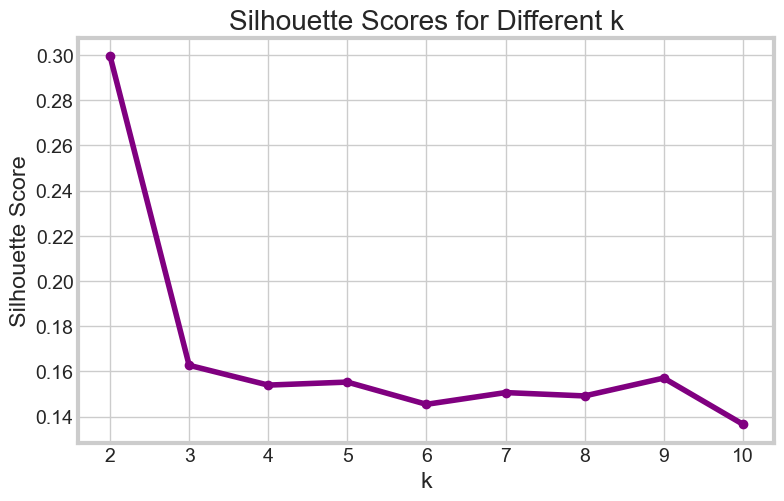

In [11]:
from sklearn.metrics import silhouette_score  # Import silhouette_score to evaluate clustering quality

silhouette_scores = []  # Create a list to store silhouette scores for each k

for k in k_values:  # Loop over different numbers of clusters
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)  # Initialize K-Means with k clusters
    labels = kmeans.fit_predict(X_scaled)  # Fit the model and get cluster labels
    score = silhouette_score(X_scaled, labels)  # Compute the silhouette score for this clustering
    silhouette_scores.append(score)  # Store the score

best_k = k_values[silhouette_scores.index(max(silhouette_scores))] # Find the k value that gives the highest silhouette score

print("Best k based on silhouette score:", best_k) # Print the optimal number of clusters

plt.figure(figsize=(8,5))  # Set the figure size
plt.plot(k_values, silhouette_scores, marker='o', color='purple')  # Plot silhouette scores and k
plt.title('Silhouette Scores for Different k')  # Set the plot title
plt.xlabel('k')  # Label the x-axis
plt.ylabel('Silhouette Score')  # Label the y-axis
plt.show()  # Show the plot

First, import silhouette_score to evaluate clustering quality

Then, an empty list is created to store the silhouette score for each tested number of clusters.

Then, loops over a range of k values and applies the K-Means algorithm to the scaled dataset for each value. After clustering, the silhouette score is calculated using the assigned cluster labels.

Then, silhouette score ranges from -1 to 1, where higher values indicate more clearly separated clusters. A higher score means that data points are closer to their own cluster and farther from neighboring clusters.

Next, identifies the value of k that produces the highest silhouette score, which is considered the optimal number of clusters, this value is printed.

Finally, a line chart is plotted showing the silhouette score for each k. This visualization helps confirm the optimal number of clusters by highlighting where the silhouette score top, making the decision easier.

In [12]:
# Initialize K-Means with the optimal number of clusters, a fixed random state for reproducibility, and 10 initializations
kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)

# Fit the K-Means model to the scaled data and assign each data point to a cluster
# The cluster labels are stored in a new column called 'cluster' in the DataFrame
df['cluster'] = kmeans.fit_predict(X_scaled)

df.head() # Show the first few rows of the DataFrame to check that the cluster assignments have been added

,genres,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,popularity,key,cluster
0,21st century classical,0.979333,0.162883,1.602977e+05,0.071317,0.606834,0.361600,-31.514333,0.040567,75.336500,0.103783,27.833333,6,1
1,432hz,0.494780,0.299333,1.048887e+06,0.450678,0.477762,0.131000,-16.854000,0.076817,120.285667,0.221750,52.500000,5,1
2,8-bit,0.762000,0.712000,1.151770e+05,0.818000,0.876000,0.126000,-9.180000,0.047000,133.444000,0.975000,48.000000,7,0
3,a cappella,0.676557,0.538961,1.906285e+05,0.316434,0.003003,0.172254,-12.479387,0.082851,112.110362,0.448249,45.820071,7,0
4,abstract,0.459210,0.516167,3.431965e+05,0.442417,0.849667,0.118067,-15.472083,0.046517,127.885750,0.307325,43.500000,1,1


First, K-Means model is initialized with best_k clusters, a fixed random_state to ensure reproducibility, and n_init=10 to run multiple times.

Next, the model is fitted to the scaled dataset, and each data point is assigned to one of the clusters. These cluster labels are stored in a new column in the DataFrame, allows you to see which cluster each data belong to.

Finally, Show the first few rows of the DataFrame, to check that the clustering has been successfully applied.

In [13]:
for i in range(best_k): # Loop over each cluster
    print(f"\nCluster {i} sample genres:") # Print a header indicating the cluster number

    # Select the rows where the cluster label equals the current cluster i
    # From these rows, randomly sample 5 genre names to show representative examples, random_state=42
    display(df[df['cluster']==i]['genres'].sample(5, random_state=42))


Cluster 0 sample genres:


2234     progressive metalcore
2406               salsa choke
791       deep adult standards
337     brazilian groove metal
2418                samba-rock
Name: genres, dtype: object


Cluster 1 sample genres:


1029    finnish contemporary classical
2718                             theme
297                   bluegrass fiddle
251                              bebop
323                            bow pop
Name: genres, dtype: object

A for loop iterates over all cluster numbers for each cluster:

header is printed to indicate the current cluster number.

Then, selects all rows in the DataFrame where the 'cluster' column equals the current cluster, from these rows, 5 genres are randomly sampled to provide representative examples of the types of genres grouped in that cluster, to understand the characteristics of each cluster and check whether the clustering has meaningfully grouped similar genres together.

Then, random_state=42 ensures that the same sample is returned each time the code is run.

In [14]:
# Group the DataFrame by the 'cluster' column, calculate the mean of all numerical features listed in num_features
cluster_summary = df.groupby('cluster')[num_features].mean()

cluster_summary # Show the resulting summary table

,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,key
cluster,,,,,,,,,,,
0,0.271636,0.579450,245059.514526,0.661427,0.136848,0.197539,-8.178779,0.088525,122.906258,0.545583,6.170591
1,0.805526,0.405253,272544.039710,0.248246,0.444025,0.177968,-17.785101,0.068141,106.890178,0.327765,5.213592


First, DataFrame is grouped by the 'cluster' column, so that all data points belonging to the same cluster are together. For each cluster, the mean of all numerical features is calculated.

Then, the table is stored in cluster_summary, shows the average feature values for each cluster which helps in understanding the characteristics of the clusters.

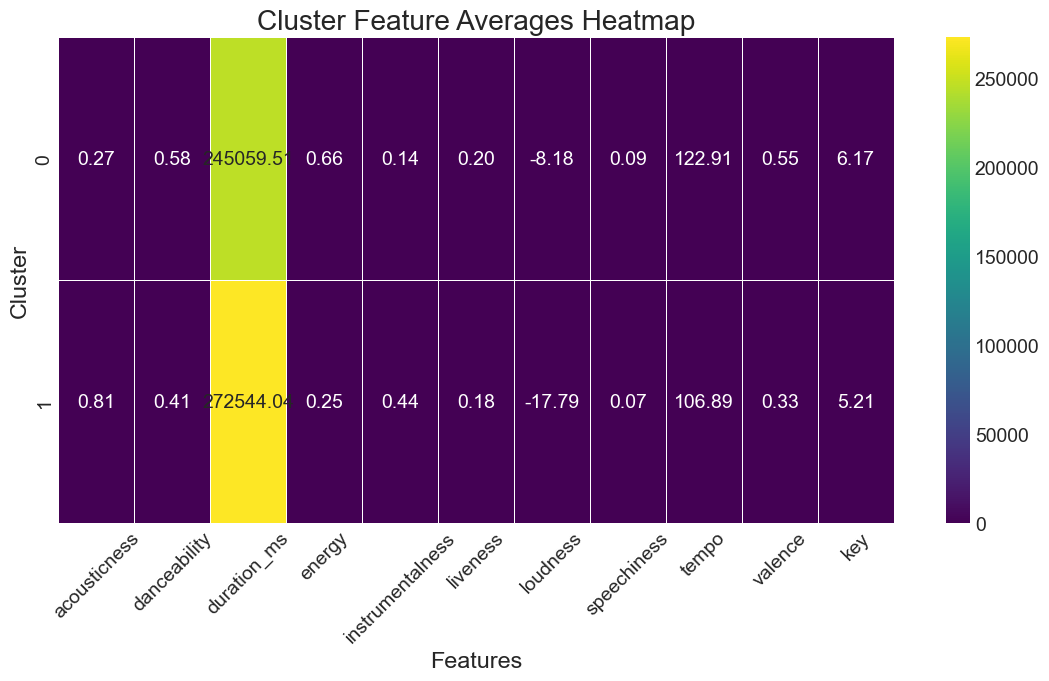

In [15]:
plt.figure(figsize=(12,6)) # Create a figure with width 12 and height 6

# cluster summary table as data for the heatmap, each cell with its numeric value, format the annotations to two decimal places
# color map for visualization, lines between cells for better separation
sns.heatmap(cluster_summary, annot=True, fmt=".2f", cmap='viridis', linewidths=0.5)

plt.xticks(rotation=45) # Rotate x-axis labels 45 degrees for readability
plt.title('Cluster Feature Averages Heatmap') # Set the title of the heatmap
plt.ylabel('Cluster') # Label the y-axis
plt.xlabel('Features') # Label the x-axis
plt.show() # Show the heatmap

First, figure of size 12x6 is created for clarity and readability.

Then, heatmap is used to display the cluster_summary table, shows the actual numeric values in each cell, formats the numbers to two decimal places then a color to highlight differences in feature values then lines between cells for better visual separation.

Then, x-axis labels are rotated 45 degrees to prevent overlapping.

Next, titles and axis labels are added to indicate that the heatmap represents cluster averages.

Finally, show the heatmap.

A heatmap is used here because we have numerical data organized by categorical groups and to compare values across multiple features and clusters, also, make it easy to see patterns, trends, and differences in the numerical data across categories, the color shows the magnitude of each value, making explanation faster than a table of numbers.

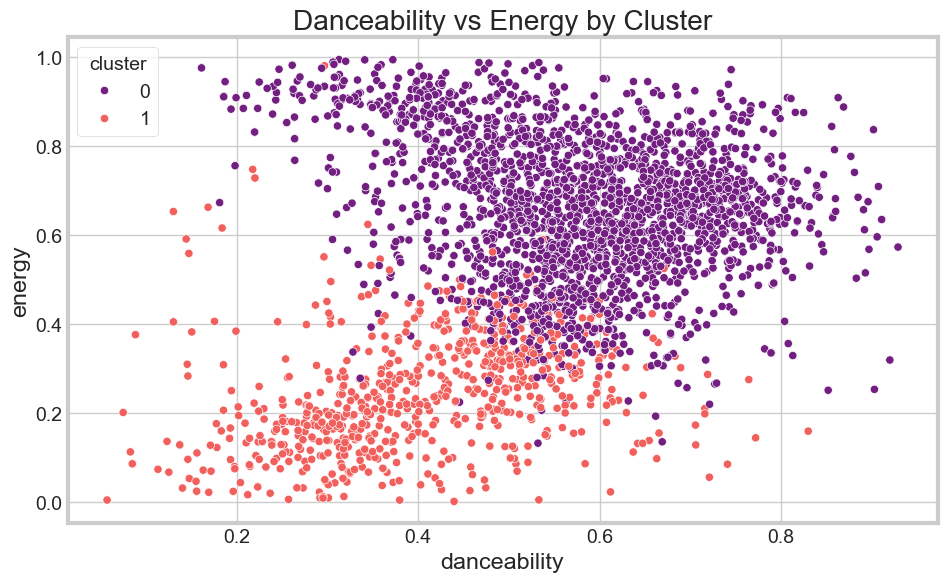

In [16]:
plt.figure(figsize=(10,6)) # Create a figure with width 10 and height 6

# Use the DataFrame df as the data source, set 'danceability' as the x-axis, set 'energy' as the y-axis
# Color the points, 'magma' color palette for clusters
sns.scatterplot(data=df, x='danceability', y='energy', hue='cluster', palette='magma')

plt.title("Danceability vs Energy by Cluster") # Set the title of the scatter plot
plt.show() # show the scatter plot

First, figure of size 10x6 is created

Then, scatter plot, x='danceability' sets the x-axis to the danceability feature, y='energy' sets the y-axis to the energy feature, hue='cluster' colors each point according to its assigned cluster, to see which songs belong to which cluster, palette='magma' applies a color gradient.

Then, title the plot

Finally, show the plot

scatter plot helps to explore the relationships between two numerical features while also showing how clusters separate in feature space, it provides insight into the characteristics of each cluster and whether clusters are well defined or overlapping, as here, scatter plot is used to visualize how songs are distributed across two numerical features which are danceability and energy also showing their cluster assignments.

In [17]:
# Compute the silhouette score for the final clustering, X_scaled is standardized feature data
# df['cluster'] contains the cluster labels assigned to each data point
final_score = silhouette_score(X_scaled, df['cluster'])
final_score # Show the final silhouette score for evaluation

0.29957722945501086

First, uses the standardized feature data and the cluster labels stored.

Then, score ranges from -1 to 1, Values close to 1 indicate that points are well clustered and far from neighboring clusters while, Values near 0 indicate overlapping clusters, negative values indicate possible misassignments.

Finally, final_score provides a numerical measure of the overall quality of the clustering.

The score is (0.29957722945501086) indicates that the clusters are distinct, but not very well separated, so, while there is some meaningful grouping of songs into clusters, there is still overlap between clusters.